## Implementing MADDPG based on full competition phase (1-competition, 0-cooperation)

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
from maddpg import MADDPG
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name="/home/punnu/Documents/Udacity/DRL/Projects/p3_collab-compet/data/Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
#get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine State Space

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# Test random agents

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     step_counter = 0
#     while True:
#         step_counter += 1
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

# Training

In [6]:
state_dim = int(env_info.vector_observations.shape[1])
action_dim = int(brain.vector_action_space_size)

In [7]:
random_seed = 41 # round(np.random.rand()*100) #select a random seed value
print(f"Random seed value: {random_seed}")

Random seed value: 41


In [8]:
#Creates 2 agents
agent = MADDPG(num_agents, state_dim, action_dim, random_seed)

In [9]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                     
        #Reset the agents noise level
        agent.reset()
        #initialize score value calculations for 2 agents
        scores_episode = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states)                   #get action from agent
            env_info = env.step(actions)[brain_name]      # send actions to the environment
            next_states = env_info.vector_observations    # get next states   
            rewards = env_info.rewards                    # get rewards   
            dones = env_info.local_done                   # see if episodes finished
            agent.step(states, actions, rewards, next_states, dones) #perform optimization
            #Append stats
            scores_episode += rewards
            states = next_states                                

            #break if any agents are done           
            if np.any(dones):
                break 
        
        #calculate intermediate stats
        score = np.max(scores_episode)
        scores_deque.append(score)
        scores.append(score)
        
        #display current stats
        print('\rEpisode {}\tAverage Score: {:.4f}\tCurrent Score: {:.4f}\t Max Score: {:.4f}'
              .format(i_episode, np.mean(scores_deque), score, np.max(scores_deque)), end="")
    
        # Save checkpoint every 100 episodes
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            #agent.saveCheckPoints(False)
        
        #break training if env solved    
        if np.mean(scores_deque) >= 0.5:
            #agent.saveCheckPoints(True)
            break
        
    return scores

In [10]:
scores = ddpg()

Episode 100	Average Score: 0.0140	Current Score: 0.0900	 Max Score: 0.1000
Episode 200	Average Score: 0.0612	Current Score: 0.0000	 Max Score: 0.2000
Episode 300	Average Score: 0.0952	Current Score: 0.1000	 Max Score: 0.4000
Episode 400	Average Score: 0.2874	Current Score: 0.4000	 Max Score: 1.7000
Episode 465	Average Score: 0.5038	Current Score: 2.6000	 Max Score: 2.6000

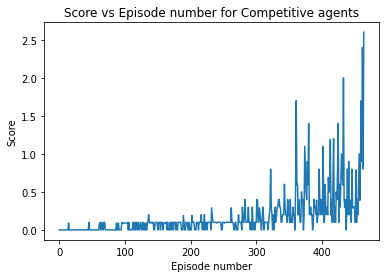

In [11]:
plt.plot(scores)
plt.xlabel("Episode number")
plt.ylabel("Score")
plt.title("Score vs Episode number for Competitive agents")
plt.show()

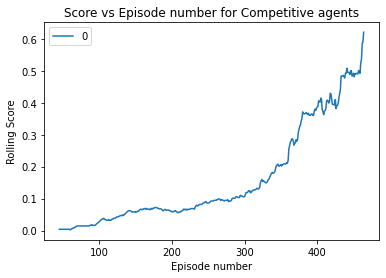

In [12]:
#perform rolling average
df = pd.DataFrame(scores)
df.rolling(window=round(0.1*len(scores))).mean().plot()
plt.xlabel("Episode number")
plt.ylabel("Rolling Score")
plt.title("Score vs Episode number for Competitive agents")
plt.show()

In [14]:
env.close()